In [1]:
### Load necessary libraries ###
import glob
import os
import librosa
import librosa.display

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [112]:
### Define helper functions ###
# Load the model.
preprocess_model = hub.load('./VGG/vggish_1')

def extract_features(parent_dir,sub_dirs,file_ext="*.wav",
                     bands=60,frames=41):
    '''
    '''

    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size // 2)
            
    window_size = 512 * (frames - 1)
    features, labels = [], []

    for fn in glob.glob(os.path.join(parent_dir, sub_dirs, file_ext)):

        # Load data with label
        vgg_embeddings, segment_labels = [], []
        sound_clip,sr = librosa.load(fn, sr=16000)
        label = int(fn.split('/')[2].split('-')[1])

        # For each generator term
        for (start,end) in _windows(sound_clip,window_size):

            # If the window size is correct 
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]

                # Run the model, check the output.
                embeddings = preprocess_model(signal)
                embeddings.shape.assert_is_compatible_with([None, 128])

                # melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
                # logspec = librosa.amplitude_to_db(melspec)
                # logspec = logspec.T.flatten()[:, np.newaxis].T

                vgg_embeddings.append(embeddings)
                segment_labels.append(label)
                # np.shape(segment_log_specgrams) = (N, 1, 2460) = (N, 1, BxF) 
                # where 2460 is 60 bands x 41 frames 

        # vgg_embeddings = np.asarray(vgg_embeddings).reshape(
        #     len(vgg_embeddings),bands,frames,1)

        # Append if not empty segment
        if len(vgg_embeddings) > 0:  
            features.append(vgg_embeddings)
            labels.append(segment_labels)
        # print(labels)
        

    return features, labels

In [113]:
# # Pre-process and extract feature from the data
parent_dir = 'UrbanSounds8K/audio/'
save_dir = "UrbanSounds8K/processed_vgg/"   
folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])

for sub_dir in sub_dirs:
    features, labels = extract_features(parent_dir,sub_dir)
    np.savez("{0}{1}".format(save_dir, sub_dir), 
             features=features, 
             labels=labels)
    print("Completed: ", sub_dir)

ValueError: cannot reshape array of size 640 into shape (5,60,41,1)

In [18]:
# Understanding the shape of the data

test_data = np.load("D:/Github/aqibsaeed/UrbanSounds8K/processed_vgg/fold2.npz", allow_pickle=True)
# x_train = train_data["features"].flatten()[:, np.newaxis]
# y_train = train_data["labels"].flatten()[:, np.newaxis]

x_train = np.concatenate(train_data["features"], axis=0) 
y_train = np.concatenate(train_data["labels"], axis=0)

x_test = test_data["features"]
y_test = test_data["labels"]
ind = 102

print("Single train sample shape: " + str(np.shape(x_train[ind])))
print("Single test sample shape: " + str(np.shape(x_test[ind])))

print("Single train label shape: " + str(np.shape(y_train[ind])))
print("Single test label shape: " + str(np.shape(y_test[ind])))

print("Single train label: " + str(y_train[ind]))
print("Single test label: " + str(y_test[ind]))

Single train sample shape: (1, 128)
Single test sample shape: (5, 1, 128)
Single train label shape: ()
Single test label shape: (5,)
Single train label: 5
Single test label: [8, 8, 8, 8, 8]


In [ ]:
for x, y in zip(x_test, y_test):
    segment_prediction = []
    for segment in x:
        # average predictions over segments of a sound clip
        print(np.shape(segment[np.newaxis,:]))
        segment_prediction.append(model.predict(segment))


    avg_p = np.argmax(np.mean(segment_prediction, axis = 0))
    y_pred.append(avg_p) 
    # pick single label via np.unique for a sound clip
    y_true.append(np.unique(y)[0]) 

In [14]:
### Define FF network architecture following VGG feature extraction ###
def get_network():
    num_classes = 10
    keras.backend.clear_session()
    
    input_shape = (1,128)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, activation="relu", input_shape = input_shape))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(.2))
    
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss=keras.losses.SparseCategoricalCrossentropy(), 
        metrics=["accuracy"])
        
    return model

model = get_network()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            16512     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 128)            1

Fold n accuracy: 0.8308823529411765
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold1\fold_0\assets
Fold n accuracy: 0.7277289836888331
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold2\fold_1\assets
Fold n accuracy: 0.6505190311418685
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold3\fold_2\assets
Fold n accuracy: 0.7560175054704595
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold4\fold_3\assets
Fold n accuracy: 0.7635294117647059
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold5\fold_4\assets
Fold n accuracy: 0.7549668874172185
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold6\fold_5\assets
Fold n accuracy: 0.770595690747782
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold7\fold_6\assets
Fold n accuracy: 0.715633423180593
INFO:tensorflow:Assets written to: VGG_FF\20220308-153752\models\fold8\fold_7\assets
Fold n accuracy: 0.780678851174934

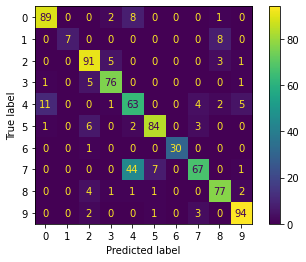

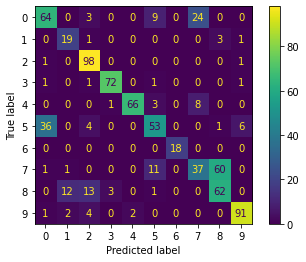

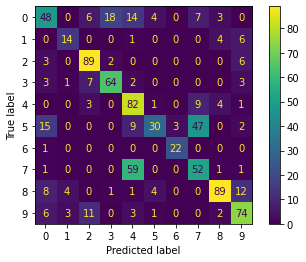

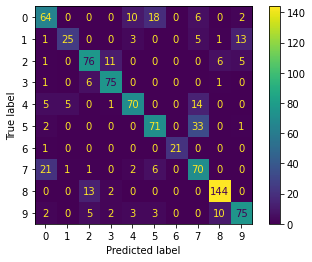

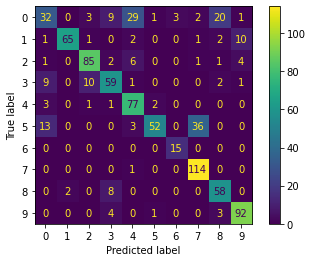

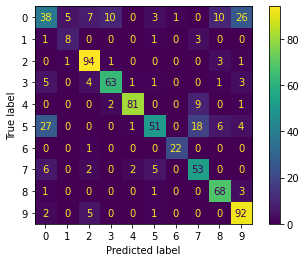

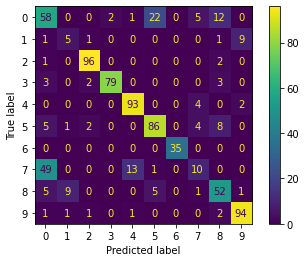

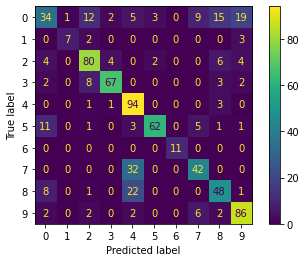

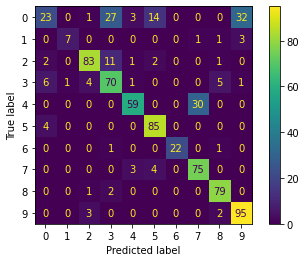

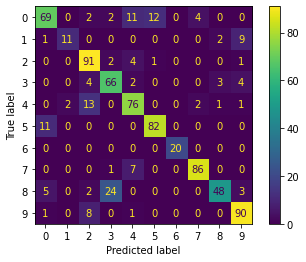

In [67]:
### Load necessary libraries ###
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import datetime

model_types = ["VGG_FF"]

for model_type in model_types:

    training_logs_path = os.path.join(model_type, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    conf_mat_path = os.path.join(training_logs_path, "conf_mats")
    os.makedirs(conf_mat_path)
    
    ### Train and evaluate via 10-Folds cross-validation ###
    accuracies = []
    folds = np.array(['fold1','fold2','fold3','fold4',
                    'fold5','fold6','fold7','fold8',
                    'fold9','fold10'])
    load_dir = "UrbanSounds8K/processed_vgg/"
    kf = KFold(n_splits=10)

    for train_index, test_index in kf.split(folds):
        log_dir = os.path.join(training_logs_path, "logs", "fit", folds[test_index][0])
        models_dir = os.path.join(training_logs_path, "models", folds[test_index][0])

        x_train, y_train = [], []
        for ind in train_index:
            # read features or segments of an audio file
            train_data = np.load("{0}/{1}.npz".format(load_dir,folds[ind]), 
                        allow_pickle=True)
            # for training stack all the segments so that they are treated as an example/instance
            features = np.concatenate(train_data["features"], axis=0) 
            labels = np.concatenate(train_data["labels"], axis=0)
            x_train.append(features)
            y_train.append(labels)

        # stack x,y pairs of all training folds 
        x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
        y_train = np.concatenate(y_train, axis = 0).astype(np.float32)
        
        # shuffle this training data because there is validation split later
        idx = np.random.permutation(len(y_train))
        x_train, y_train = x_train[idx], y_train[idx]
        
        # for testing we will make predictions on each segment and average them to 
        # produce single label for an entire sound clip.
        test_data = np.load("{0}/{1}.npz".format(load_dir,
                    folds[test_index][0]), allow_pickle=True)

        # x_test = np.concatenate(test_data["features"], axis=0)
        # y_test = np.concatenate(test_data["labels"], axis=0)
        
        x_test = test_data["features"]
        y_test = test_data["labels"]
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        model = get_network()
        

        # fit model
        model.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 0, validation_split=0.1, 
                    use_multiprocessing=True, workers=8, callbacks=[tensorboard_callback])
        
        # evaluate on test set/fold
        y_true, y_pred = [], []
        for x, y in zip(x_test, y_test):
            
            # average predictions over segments of a sound clip
            segment_prediction = []
            for segment in x:
                segment_prediction.append(model.predict(segment[np.newaxis,:]))
            avg_p = np.argmax(np.mean(segment_prediction, axis = 0))

            # # average predictions over segments of a sound clip
            # avg_p = np.argmax(np.mean(model.predict(x), axis = 0))

            y_pred.append(avg_p) 
            # pick single label via np.unique for a sound clip
            y_true.append(np.unique(y)[0]) 

        accuracies.append(accuracy_score(y_true, y_pred))    
        print("Fold n accuracy: {0}".format(accuracy_score(y_true, y_pred)))

        cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
        cm.figure_.savefig(os.path.join(conf_mat_path, "fold_" + str(test_index[0]) + '_acc_' + str(accuracy_score(y_true, y_pred))) + '.png',dpi=1000)

        model.save(os.path.join(models_dir, "fold_" +  str(test_index[0])))

    print("Average 10 Folds Accuracy: {0}".format(np.mean(accuracies)))

In [51]:
training_logs_path = os.path.join(model_type, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
conf_mat_path = os.path.join(training_logs_path, "conf_mats")
os.makedirs(conf_mat_path)

log_dir = os.path.join(training_logs_path, "logs", "fit", folds[test_index][0])
print(log_dir)

VGG_FF\20220308-151636\logs\fit\fold1


In [62]:
print(os.path.join("models_dir", "fold_" +  str(test_index[0])))


models_dir\fold_0


In [100]:
model.predict(x_train[0])
model.predict(x_test[0])

array([[1.2715578e-08, 3.4341339e-13, 7.3817233e-04, 9.9926120e-01,
        1.4916118e-08, 2.1915948e-10, 1.2422017e-08, 1.0803437e-11,
        4.1766020e-07, 1.8998691e-07]], dtype=float32)